# Imports

In [1]:
from itertools import combinations, groupby, product
from scipy.spatial.distance import squareform
from numpy import cos, sin, tan, exp, pi
from scipy.integrate import quad
from collections import Counter
from scipy.special import iv
from toolz import partial


import time
import scipy
import numpy as np
import pandas as pd
# import ringity as rng
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

# Visuals

In [2]:
cemm1 = [0/255,85/255,100/255]
cemm2 = [0/255,140/255,160/255]

node_col = cemm1
edge_col = cemm2

def plot_nx(G, 
            pos=None, 
            ax=None, 
            name='nx.pdf', 
            node_colors = None,
            node_alpha  = 0.3, 
            edge_colors = None,
            edge_alpha  = 0.2,
            path=None, 
            silence=False,
            **kwargs):

    if pos is None:
        pos = nx.spring_layout(G)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8));
        fig.patch.set_alpha(0)
    if node_colors is None:
        node_colors = [node_col for v in G.nodes]
    if edge_colors is None:
        edge_colors = [edge_col for u,v in G.edges]
    nodes = nx.draw_networkx_nodes(G, pos=pos, alpha=node_alpha, ax=ax, node_color=node_colors, node_size=15, linewidths=1)
    edges = nx.draw_networkx_edges(G, pos=pos, alpha=edge_alpha, ax=ax, edge_color=edge_colors)
    ax.axis('off');
    
    if path is None:
        path = f'dummy/{name}'
    plt.savefig(path, transparent=True, **kwargs);
    
    if silence:
        plt.close()

# Preparation

### Decorator

In [3]:
def support(f, left_limit, right_limit):
    """This function can be used as a decorater 
    to restrict the support of its input function."""
    def f_rest(x, *args, **kwargs):
        return np.where(left_limit <= x <= right_limit, f(x, *args, **kwargs), 0)
    return f_rest

### Mi functions

In [4]:
@partial(np.vectorize, excluded={'kappa', 'limit'})
def SvM(x, kappa, limit=100):
    """Big Me."""
    return scipy.integrate.quad(lambda t : vM(t, kappa=kappa), 0, x, limit=limit)[0]

@partial(np.vectorize, excluded={'kappa', 'limit'})
def vM(x, kappa, limit=100):
    """Small Me."""
    return scipy.integrate.quad(lambda t : iv(0,2*kappa*cos(t/2)), 0, x, limit=limit)[0]

@partial(np.vectorize, excluded='kappa')
def dvM(t, kappa):
    return iv(0,2*kappa*cos(t/2))

### Unconditional distributions

In [5]:
@partial(np.vectorize, excluded='kappa')
@partial(support, left_limit=0, right_limit=pi)
def f_delta(t ,kappa):
    return dvM(t,kappa=kappa)/(pi*iv(0,kappa)**2)

@partial(np.vectorize, excluded='kappa')
@partial(support, left_limit=0, right_limit=np.inf)
def F_delta(t, kappa):
    return np.where(t<pi, vM(t, kappa=kappa)/(pi*iv(0,kappa)**2), 1)


@partial(np.vectorize, excluded={'kappa', 'a'})
@partial(support, left_limit=0, right_limit=1)
def f_s(t, kappa, a):
    return 2*a*pi*f_delta(2*a*pi*(1-t),kappa=kappa)

@partial(np.vectorize, excluded={'kappa', 'a'})
@partial(support, left_limit=0, right_limit=np.inf)
def F_s(t, kappa, a):
    return 1 - F_delta(2*a*pi*(1-t),kappa=kappa)


@partial(np.vectorize, excluded={'rho', 'eta', 'kappa', 'a'})
@partial(support, left_limit=0, right_limit=1)
def f_P(t, rho, eta, kappa, a):
    if eta == 0:
        return 0.
    alpha, beta = get_alpha_beta(rho=rho, eta=eta, kappa=kappa, a=a)
    ppf = scipy.stats.beta.ppf(t, a=alpha, b=beta)
    return f_s(ppf, kappa=kappa, a=a)/scipy.stats.beta.pdf(ppf, a=alpha, b=beta)


@partial(np.vectorize, excluded={'rho', 'eta', 'kappa', 'a'})
@partial(support, left_limit=0, right_limit=1)
def f_P_mu(t, mu, eta):
    if eta == 0:
        return 0.
    nu = (1-eta)/eta
    alpha =   mu  *nu
    beta  = (1-mu)*nu
    ppf = scipy.stats.beta.ppf(t, a=alpha, b=beta)
    return f_s(ppf, kappa=kappa, a=a)/scipy.stats.beta.pdf(ppf, a=alpha, b=beta)

@partial(np.vectorize, excluded={'rho', 'eta', 'kappa', 'a'})
@partial(support, left_limit=0, right_limit=np.inf)
def F_P(t, rho, eta, kappa, a):
    if eta == 0:
        ppf = np.where(t < 1, 1-rho, 1)
    else:
        alpha, beta = get_alpha_beta(rho=rho, eta=eta, kappa=kappa, a=a)
        ppf = scipy.stats.beta.ppf(t, a=alpha, b=beta)
    return F_s(ppf, kappa=kappa, a=a)

@partial(np.vectorize, excluded={'rho', 'eta', 'kappa', 'a'})
@partial(support, left_limit=0, right_limit=np.inf)
def F_P_mu(t, mu, eta):
    if eta == 0:
        ppf = np.where(t < 1, mu, 1)
    else:
        nu = (1-eta)/eta
        alpha =   mu  *nu
        beta  = (1-mu)*nu
        ppf = scipy.stats.beta.ppf(t, a=alpha, b=beta)
    return F_s(ppf, kappa=kappa, a=a)

### Conditional distributions

In [6]:
@partial(np.vectorize, excluded={'theta', 'kappa'})
@partial(support, left_limit=0, right_limit=pi)
def cond_Delta(x, theta, kappa):
    return (exp(kappa*cos(theta+x)) + exp(kappa*cos(theta-x)))/(2*pi*iv(0,kappa))

@partial(np.vectorize, excluded={'theta', 'kappa'})
@partial(support, left_limit=0, right_limit=pi)
def Cond_Delta(x, theta, kappa):
    return scipy.integrate.quad(lambda t : exp(kappa*cos(theta-t))/(2*pi*iv(0,kappa)), -x, x)[0]


@partial(np.vectorize, excluded={'theta', 'kappa', 'a'})
@partial(support, left_limit=0, right_limit=1)
def cond_s(t, theta, kappa, a):
    return 2*a*pi*cond_Delta(2*a*pi*(1-t), theta=theta, kappa=kappa)

@partial(np.vectorize, excluded={'theta', 'kappa', 'a'})
@partial(support, left_limit=0, right_limit=np.inf)
def Cond_s(t, theta, kappa, a):
    return np.where(2-1/a < t, 1 - Cond_Delta(2*a*pi*(1-t), theta=theta, kappa=kappa), 0)


@partial(np.vectorize, excluded={'theta', 'kappa', 'a', 'A', 'B'})
@partial(support, left_limit=0, right_limit=1)
def cond_P(t, theta, mu, eta):
    nu = (1-eta)/eta
    alpha =   mu  *nu
    beta  = (1-mu)*nu
    ppf = scipy.stats.beta.ppf(t, a=alpha, b=beta)
    return cond_s(ppf, theta=theta, kappa=kappa, a=a)/scipy.stats.beta.pdf(ppf, a=alpha, b=beta)

@partial(np.vectorize, excluded={'theta', 'kappa', 'a', 'A', 'B'})
@partial(support, left_limit=0, right_limit=np.inf)
def Cond_P(t, theta, mu, eta):
    nu = (1-eta)/eta
    alpha =   mu  *nu
    beta  = (1-mu)*nu
    ppf = scipy.stats.beta.ppf(t, a=alpha, b=beta)
    return Cond_s(ppf, theta=theta, kappa=kappa, a=a)

### Interaction probability function

In [7]:
@partial(np.vectorize, excluded={'a'})
@partial(support, left_limit=0, right_limit=np.inf)
def WS_integral(mu, a):
    return F_delta(2*a*pi*(1-mu), kappa=kappa)

@partial(np.vectorize, excluded={'rho'})
@partial(support, left_limit=0, right_limit=np.inf)
def WS(t, mu):
    return np.where(t < mu, 0, 1)

@partial(np.vectorize, excluded={'rho'})
@partial(support, left_limit=0, right_limit=np.inf)
def ER(t, mu):
    return 1-mu # INCOMPLETE !

In [8]:
@partial(np.vectorize, excluded={'rho'})
@partial(support, left_limit=0, right_limit=np.inf)
def integral(mu, eta, kappa, a):
    if eta == 0:
        return F_delta(2*a*pi*(1-mu), kappa=kappa)
    else:
        nu = (1-eta)/eta
        alpha =   mu  *nu
        beta  = (1-mu)*nu
        return 2*pi*a*quad(lambda t: scipy.stats.beta.cdf(t, a=alpha, b=beta)*f_delta(2*pi*a*(1-t), kappa=kappa), 0, 1)[0]


def get_mu(rho, eta, kappa, a):    
    if kappa == 0:
        mu = 1-rho/(2*a)
    elif eta == 0:
        mu = scipy.optimize.newton(lambda mu: integral(mu, eta=eta, kappa=kappa, a=a)-rho, 1-rho/(2*a), 
                                   fprime = lambda mu: -2*a*pi*f_delta(2*a*pi*(1-mu), kappa=kappa),
                                   maxiter=100)
    else:
        mu = scipy.optimize.newton(lambda mu: integral(mu, eta=eta, kappa=kappa, a=a)-rho, 1-rho/(2*a), maxiter=100)
    return mu

def get_alpha_beta(rho, eta, kappa, a):
    mu = get_mu(rho=rho, eta=eta, kappa=kappa, a=a)
    nu = (1-eta)/eta
    alpha =   mu  *nu
    beta  = (1-mu)*nu
    return alpha, beta

def get_ipf(mu, eta):
    if eta == 0:
        return partial(WS, mu=mu)
    elif eta == 1:
        return partial(ER, mu=mu)
    else:
        nu = (1-eta)/eta
        alpha =   mu  *nu
        beta  = (1-mu)*nu    
        return partial(scipy.stats.beta.cdf, a=alpha, b=beta)

### Degree distribution

In [9]:
@partial(np.vectorize, excluded={'mu', 'eta'})
@partial(support, left_limit=-pi, right_limit=pi)
def rho_dot(theta, mu, eta):
    nu = (1-eta)/eta
    alpha =   mu  *nu
    beta  = (1-mu)*nu
    return quad(lambda t : scipy.stats.beta.cdf(t, a=alpha, b=beta)*cond_s(t, theta=theta, kappa=kappa, a=a), 0, 1)[0]

def deg_distribution(N, kappa, mu, eta, size=2**7):
    thetas = np.random.vonmises(mu=0, kappa=kappa, size=size)
    p_count = rho_dot(thetas, mu=mu, eta=eta)
    return {i:np.mean(scipy.stats.binom.pmf(i, n=N-1, p=p_count)) for i in range(N)}

### Main

In [10]:
def overlap(d, a):
    x1 = np.where(2*pi*a-d     > 0, 2*pi*a-d    , 0)
    x2 = np.where(d-2*pi*(1-a) > 0, d-2*pi*(1-a), 0)   
    return x1 + x2 

In [11]:
def MY_numpy_model(
    N, 
    rho,
    eta   = 0,
    kappa = 0,
    a     = 0.5,
    verbose = False):

    assert 0 <= kappa
    assert 0 <  a  <= 0.5
    
    mu = get_mu(rho=rho, eta=eta, kappa=kappa, a=a)
    ipf = get_ipf(mu=mu, eta=eta)
    
    times = np.random.vonmises(mu=0, kappa=kappa, size=N)
    
    abs_dist = scipy.spatial.distance.pdist(times.reshape(N,1))
    sqNDM = np.where(abs_dist<pi, abs_dist, 2*pi-abs_dist)
    sqNSM = overlap(sqNDM, a)/(2*pi*a)
    sqNPM = ipf(sqNSM)
        
    if verbose:
        x = [cos(2*pi*t) for t in times]
        y = [sin(2*pi*t) for t in times]
        plt.plot(x, y, '*', markersize=1);
        plt.axis('off')
    
    return times, tuple(map(squareform, [sqNDM, sqNSM, sqNPM]))

# Realisations

In [51]:
sample_size = 2**4

default = 0.05

N   = 2**10
rho = default

eta   = default
kappa = 10*default/(1-10*default)
a     = 0.5 - default/2

times_list = []
NDM_list = []
NSM_list = []
NPM_list = []

deg_list   = []

fullscore_list = []
thinscore_list = []

t1 = time.time()

for i in range(sample_size):
    times, (NDM, NSM, NPM) = MY_numpy_model(N=N, rho=rho, eta=eta, kappa=kappa, a=a, verbose=False)
    
    times_list.append(times)
    NDM_list.append(NDM)
    NSM_list.append(NSM)
    NPM_list.append(NPM)
    
    R = squareform(np.random.uniform(size=round(N*(N-1)/2)))
    A = np.where(NPM>R, 1, 0)
    G = nx.from_numpy_array(A)
    deg_list += [deg for _,deg in G.degree]
    
#    fullscore_list.append(rng.diagram(1-NPM).GGS)
#    thinscore_list.append(rng.diagram(G, induce=True).GGS)

t2 = time.time()
print(f'time: {t2-t1}sek')

time: 18.25587511062622sek


In [52]:
t1 = time.time()
mu = get_mu(rho=rho, eta=eta, kappa=kappa, a=a)
print(mu)
t2 = time.time()
print(f'time: {t2-t1}sek')

0.9627844436095507
time: 0.6861000061035156sek


In [53]:
print(rho, nx.density(G))

0.05 0.04879375916422287


In [39]:
pos = {node: (cos(times[node]), sin(times[node])) for node in G.nodes()}

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


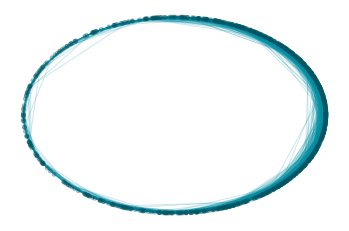

In [40]:
nx_fig = plt.figure()
ax = nx_fig.gca()
plot_nx(G, pos=pos, ax=ax)

In [41]:
nx_fig.savefig('../../Dropbox/cemm/figures/figure3/x_nx.pdf');
nx_fig.savefig('../../Dropbox/cemm/figures/figure3/x_nx.png', transparent=True);

# Degree distribution

In [42]:
sim_size = 2**12
t1 = time.time()
deg_dict = deg_distribution(N=N, kappa=kappa, mu=mu, eta=eta, size=sim_size)
t2 = time.time()
print(t2-t1)

327.72306513786316


In [43]:
degCount_obs = Counter(sorted(deg_list))
degs_obs, cnts_obs = zip(*degCount_obs.items())
cnts_obs = np.array(cnts_obs)/sample_size

In [44]:
cnts_exp = [deg_dict[deg]*N for deg in degs_obs]

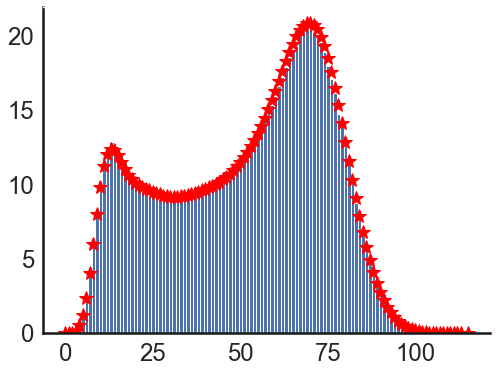

In [45]:
width = 1

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(np.array(degs_obs), cnts_obs, width=width, color='b');
ax.plot(np.array(degs_obs), cnts_exp, '*', markersize=15, color='red');

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

In [46]:
deg_fig.savefig('../../Dropbox/cemm/figures/figure3/x_deg.pdf');

# Testing unconditional distributions

### Distribution of the distance $D$

In [54]:
bins = 51

weights = np.sort(np.concatenate([squareform(NDM) for NDM in NDM_list]))
freq, delta = np.histogram(weights, bins=bins)
delta  = np.array([(a+b)/2 for a,b in zip(delta[:-1],delta[1:])])

width = delta[1]-delta[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0, pi, 101)

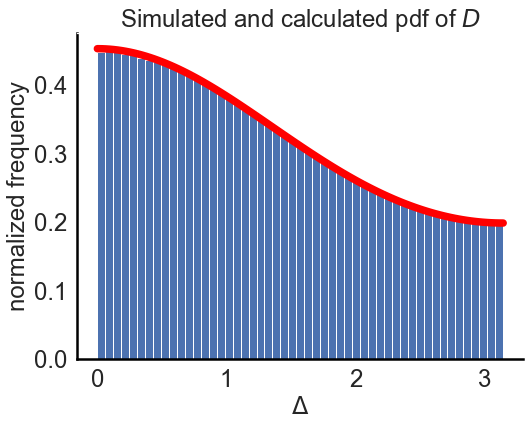

In [55]:
delta_pdf_fig, ax = plt.subplots(figsize=(8,6))
delta_pdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(delta, freq, width=width, color='b', log=False);
ax.plot(x, f_delta(x, kappa=kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$\Delta$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $D$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

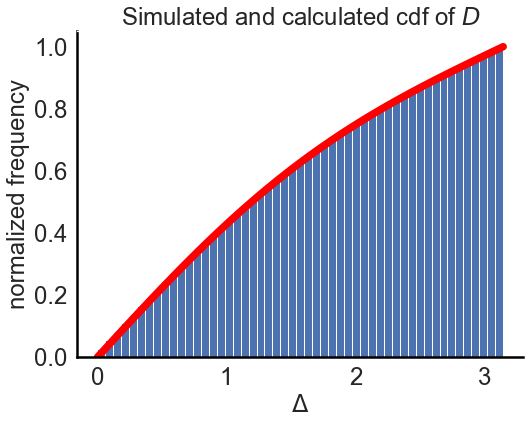

In [56]:
delta_cdf_fig, ax = plt.subplots(figsize=(8,6))
delta_cdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(delta, cumfreq, width=width, color='b');
ax.plot(x, F_delta(x,kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$\Delta$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $D$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

### Distribution of the similarity $S$

In [57]:
bins = 51

weights = np.sort(np.concatenate([squareform(NSM) for NSM in NSM_list]))
freq, s = np.histogram(weights, bins=bins, range=(0,1))
s  = np.array([(a+b)/2 for a,b in zip(s[:-1],s[1:])])

width = s[1]-s[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0,1, 101)

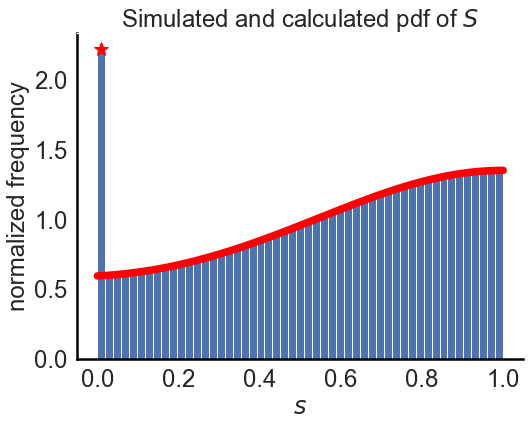

In [58]:
s_pdf_fig, ax = plt.subplots(figsize=(8,6))
s_pdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(s, freq, width=width, color='b', log=False);
ax.plot(x, f_s(x, kappa=kappa, a=a), color='red', linewidth=7.5);
ax.plot(max(2-1/a,0)+width/2, freq[0], '*', color='red', markersize=15);

ax.set_xlabel(r'$s$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $S$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

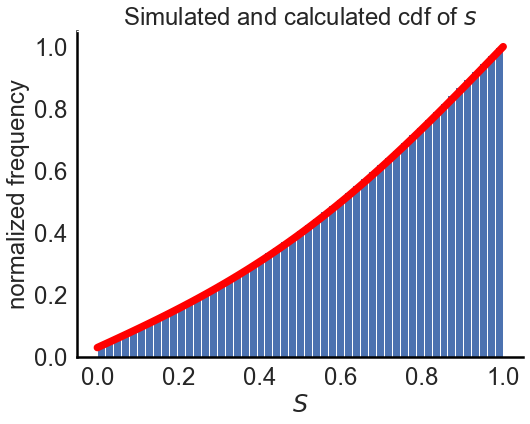

In [59]:
s_cdf_fig, ax = plt.subplots(figsize=(8,6))
s_cdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(s, cumfreq, width=width, color='b');
ax.plot(x, F_s(x,kappa=kappa, a=a), color='red', linewidth=7.5);

ax.set_xlabel(r'$S$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $s$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

### Distribution of the interaction probability $P$

In [60]:
bins = 51

weights = np.sort(np.concatenate([squareform(NPM) for NPM in NPM_list]))
freq, P = np.histogram(weights, bins=bins, range=(0,1))
P  = np.array([(a+b)/2 for a,b in zip(P[:-1],P[1:])])

width = P[1]-P[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0,1, 501)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


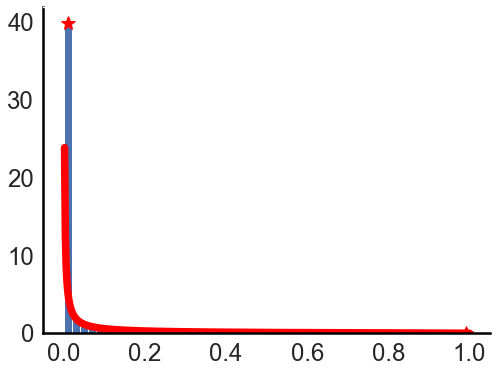

In [61]:
P_pdf_fig, ax = plt.subplots(figsize=(8,6))
P_pdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(P, freq, width=width, color='b', log=False);
ax.plot(x, f_P_mu(x, mu=mu, eta=eta), color='red', linewidth=7.5);
ax.plot(width/2, freq[0], '*', color='red', markersize=15);
ax.plot(1-width/2, freq[-1], '*', color='red', markersize=15);

# ax.set_xlabel(r'$P$', fontsize=24)
# ax.set_ylabel('normalized frequency', fontsize=24)
# ax.set_title(r'Simulated and calculated pdf of $P$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

In [62]:
P_pdf_fig.savefig('../../Dropbox/cemm/figures/figure3/x_pdf.pdf')

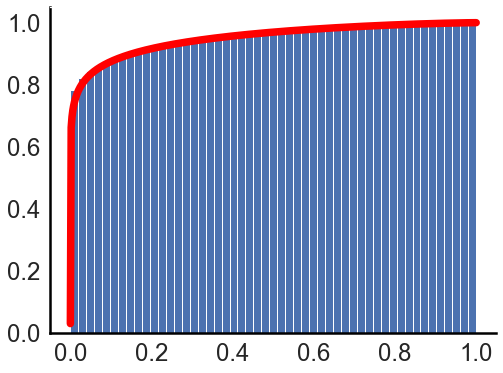

In [63]:
P_cdf_fig, ax = plt.subplots(figsize=(8,6))
P_cdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(P, cumfreq, width=width, color='b');
ax.plot(x, F_P_mu(x, mu=mu, eta=eta), color='red', linewidth=7.5);

# ax.set_xlabel(r'$P$', fontsize=24)
# ax.set_ylabel('normalized frequency', fontsize=24)
# ax.set_title(r'Simulated and calculated cdf of $P$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

In [64]:
P_cdf_fig.savefig('../../Dropbox/cemm/figures/figure3/x_cdf.pdf')

# Testing conditional distributions

### Choosing a node

In [106]:
n = np.random.randint(N)
theta = times[n]

### Distribution of the conditional distance $D_{\vartheta}$

In [107]:
bins = 51

weights = np.sort(NDM[n,:])
freq, delta = np.histogram(weights, bins=bins)
delta  = np.array([(a+b)/2 for a,b in zip(delta[:-1],delta[1:])])

width = delta[1]-delta[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0, pi, 101)

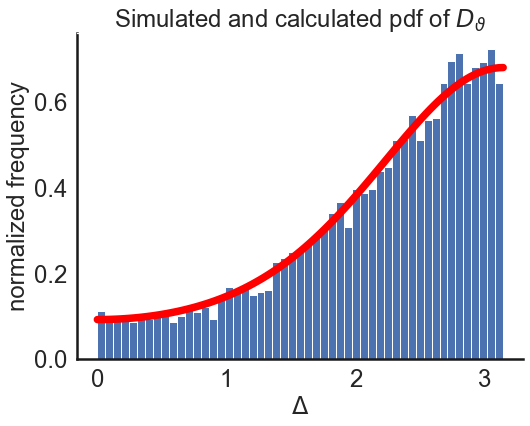

In [108]:
pdf_fig, ax = plt.subplots(figsize=(8,6))
pdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(delta, freq, width=width, color='b');
ax.plot(x, cond_Delta(x, theta=theta, kappa=kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$\Delta$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $D_{\vartheta}}$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

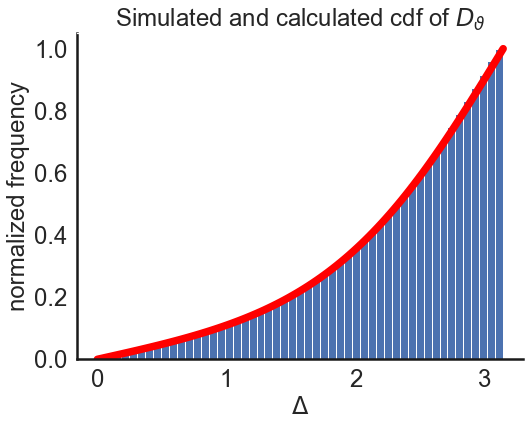

In [109]:
cdf_fig, ax = plt.subplots(figsize=(8,6))
cdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(delta, cumfreq, width=width, color='b');
ax.plot(x, Cond_Delta(x, theta=theta, kappa=kappa), color='red', linewidth=7.5);

ax.set_xlabel(r'$\Delta$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $D_{\vartheta}}$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

### Distribution of the conditional similarity $S_{\vartheta}$

In [110]:
bins = 51

weights = np.sort(NSM[n,:])
freq, s = np.histogram(weights, bins=bins)
s  = np.array([(a+b)/2 for a,b in zip(s[:-1],s[1:])])

width = s[1]-s[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*(width))

x = np.linspace(0,1, 101)

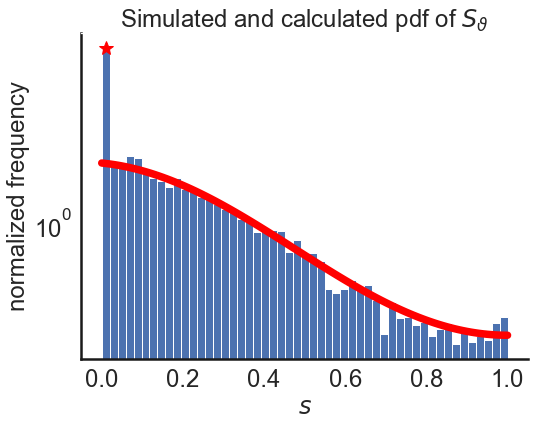

In [111]:
pdf_fig, ax = plt.subplots(figsize=(8,6))
pdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(s, freq, width=width, color='b', log=True);
ax.plot(x, cond_s(x, theta=theta, kappa=kappa, a=a), color='red', linewidth=7.5);
ax.plot(s[0], freq[0] , '*', color='red', markersize=15);

ax.set_xlabel(r'$s$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $S_{\vartheta}$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

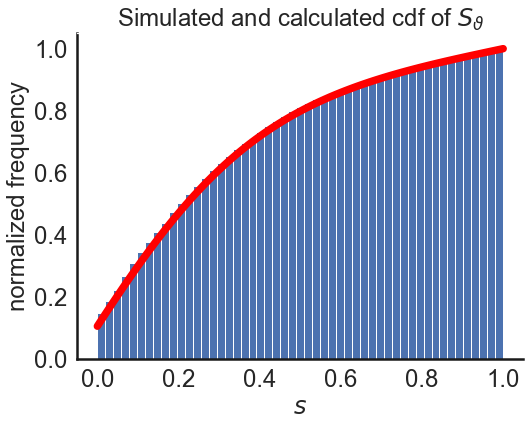

In [112]:
cdf_fig, ax = plt.subplots(figsize=(8,6))
cdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

cumfreq = (width)*np.cumsum(freq)

ax.bar(s, cumfreq, width=width, color='b');
ax.plot(x, Cond_s(x, theta=theta, kappa=kappa, a=a), color='red', linewidth=7.5);

ax.set_xlabel(r'$s$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $S_{\vartheta}}$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

### Distribution of the conditional interaction probability $P_{\vartheta}$

In [113]:
bins = 51

weights = np.sort(NPM[n,:])
freq, P = np.histogram(weights, bins=bins, range=(0,1))
P  = np.array([(a+b)/2 for a,b in zip(P[:-1],P[1:])])

width = P[1]-P[0]

freq = np.array(freq)
freq = freq/(np.sum(freq)*width)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


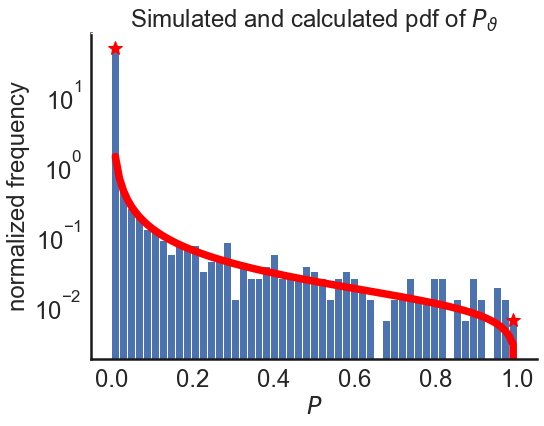

In [114]:
pdf_fig, ax = plt.subplots(figsize=(8,6))
pdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(P, freq, width=width, color='b', log=True);
ax.plot(x, cond_P(x, theta=theta, mu=mu, eta=eta), color='red', linewidth=7.5);
ax.plot(P[0], freq[0] , '*', color='red', markersize=15);
ax.plot(P[-1], freq[-1] , '*', color='red', markersize=15);

ax.set_xlabel(r'$P$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated pdf of $P_{\vartheta}}$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

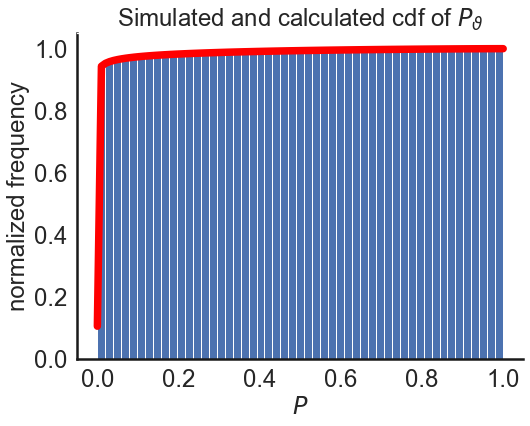

In [115]:
cdf_fig, ax = plt.subplots(figsize=(8,6))
cdf_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

cumfreq = width*np.cumsum(freq)

ax.bar(P, cumfreq, width=width, color='b');
ax.plot(x, Cond_P(x, theta=theta, mu=mu, eta=eta), color='red', linewidth=7.5);


ax.set_xlabel(r'$P$', fontsize=24)
ax.set_ylabel('normalized frequency', fontsize=24)
ax.set_title(r'Simulated and calculated cdf of $P_{\vartheta}}$', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

## Small world experiment

In [65]:
import os
import re
from collections import OrderedDict

### Producing data

In [66]:
N = 2**10
k = 18

rho = k/(N-1)

In [68]:
p_list = np.append(0, np.logspace(-5,0,20))

t1 = time.time()

for i in range(1):
    for j,p in enumerate(p_list):
        
        t_tmp = time.time()
        print(f'{i}-{j}: {t_tmp-t1:.2f}sec', end='\r')
    
        G = nx.watts_strogatz_graph(N,k,p)
        wsL = nx.average_shortest_path_length(G)
        wsC = nx.average_clustering(G)

        with open(f'data/little_big_planet/ws/L{p:.6f}_WS_N{N}_k{k}.txt', 'a') as file:
            file.write(str(wsL)+'\n')
        with open(f'data/little_big_planet/ws/C{p:.6f}_WS_N{N}_k{k}.txt', 'a') as file:
            file.write(str(wsC)+'\n')
        
        
        times, (NDM, NSM, NPM) = MY_numpy_model(N=N, eta=p, rho=rho, verbose=False)
        R = squareform(np.random.uniform(size=round(N*(N-1)/2)))
        A = np.where(NPM>R, 1, 0)
        G = nx.from_numpy_array(A)
        
        if not nx.is_connected(G):
            print('It happened!')
            continue
        
        myL = nx.average_shortest_path_length(G)
        myC = nx.average_clustering(G)
        
        with open(f'data/little_big_planet/my/L{p:.6f}_MY_N{N}_k{k}.txt', 'a') as file:
            file.write(str(myL)+'\n')
        with open(f'data/little_big_planet/my/C{p:.6f}_MY_N{N}_k{k}.txt', 'a') as file:
            file.write(str(myC)+'\n')
            
t2 = time.time()

### Watts-Strogatz

In [131]:
WS_L_25   = {}
WS_L_mean = {}
WS_L_75   = {}

WS_C_25   = {}
WS_C_mean = {}
WS_C_75   = {}

for name in os.listdir('data/little_big_planet/ws'):
    if not name.endswith('.txt'):
        continue
        
    df = pd.DataFrame(pd.Series(np.genfromtxt(f'data/little_big_planet/ws/{name}')))
    prop, p = name.split('_')[0][0], float(name.split('_')[0][1:])
    
    if prop == 'L':
        WS_L_25[p]   = np.array(df.describe().loc['25%'])
        WS_L_mean[p] = np.array(df.describe().loc['mean'])
        WS_L_75[p]   = np.array(df.describe().loc['75%'])
    
    elif prop == 'C':
        WS_C_25[p]   = np.array(df.describe().loc['25%'])
        WS_C_mean[p] = np.array(df.describe().loc['mean'])
        WS_C_75[p]   = np.array(df.describe().loc['75%'])

In [132]:
p, ws_L_25   = map(np.array, zip(*sorted(WS_L_25.items())))
p, ws_L_mean = map(np.array, zip(*sorted(WS_L_mean.items())))
p, ws_L_75   = map(np.array, zip(*sorted(WS_L_75.items())))

p, ws_C_25   = map(np.array, zip(*sorted(WS_C_25.items())))
p, ws_C_mean = map(np.array, zip(*sorted(WS_C_mean.items())))
p, ws_C_75   = map(np.array, zip(*sorted(WS_C_75.items())))

ws_L0 = ws_L_mean[0]
ws_C0 = ws_C_mean[0]

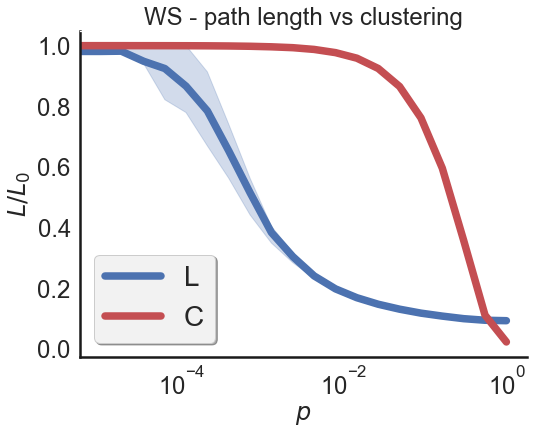

In [133]:
WS_fig, ax = plt.subplots(figsize=(8,6))
WS_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

plt.semilogx(p, ws_L_mean/ws_L0, linewidth=7.5, color='b', label='L');
plt.semilogx(p, ws_C_mean/ws_C0, linewidth=7.5, color='r' , label='C');

plt.fill_between(p, ws_L_25.flatten()/ws_L0 , ws_L_75.flatten()/ws_L0 , alpha=0.25, color='b');
plt.fill_between(p, ws_C_25.flatten()/ws_C0 , ws_C_75.flatten()/ws_C0 , alpha=0.25, color='r');

ax.set_xlabel(r'$p$', fontsize=24)
ax.set_ylabel(r'$L/L_0$', fontsize=24)
ax.set_title('WS - path length vs clustering', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

ax.legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);

### New Model

In [134]:
MY_L_25   = {}
MY_L_mean = {}
MY_L_75   = {}

MY_C_25   = {}
MY_C_mean = {}
MY_C_75   = {}

for name in os.listdir('data/little_big_planet/my'):
    if not name.endswith('.txt'):
        continue
        
    df = pd.DataFrame(np.genfromtxt(f'data/little_big_planet/my/{name}'))
    prop, p = name.split('_')[0][0], float(name.split('_')[0][1:])
    
    if prop == 'L':
        MY_L_25[p]   = np.array(df.describe().loc['25%'])
        MY_L_mean[p] = np.array(df.describe().loc['mean'])
        MY_L_75[p]   = np.array(df.describe().loc['75%'])
    
    elif prop == 'C':
        MY_C_25[p]   = np.array(df.describe().loc['25%'])
        MY_C_mean[p] = np.array(df.describe().loc['mean'])
        MY_C_75[p]   = np.array(df.describe().loc['75%'])

In [135]:
p, my_L_25   = map(np.array, zip(*sorted(MY_L_25.items())))
p, my_L_mean = map(np.array, zip(*sorted(MY_L_mean.items())))
p, my_L_75   = map(np.array, zip(*sorted(MY_L_75.items())))

p, my_C_25   = map(np.array, zip(*sorted(MY_C_25.items())))
p, my_C_mean = map(np.array, zip(*sorted(MY_C_mean.items())))
p, my_C_75   = map(np.array, zip(*sorted(MY_C_75.items())))

my_L0 = my_L_mean[0]
my_C0 = my_C_mean[0]

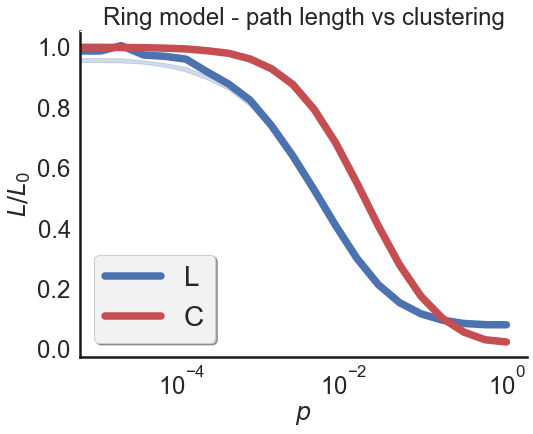

In [139]:
MY_fig, ax = plt.subplots(figsize=(8,6))
MY_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

plt.semilogx(p, my_L_mean/my_L0, linewidth=7.5, color='b', label='L');
plt.semilogx(p, my_C_mean/my_C0, linewidth=7.5, color='r' , label='C');

plt.fill_between(p, my_L_25.flatten()/my_L0 , my_L_75.flatten()/my_L0 , alpha=0.25, color='b');
plt.fill_between(p, my_C_25.flatten()/my_C0 , my_C_75.flatten()/my_C0 , alpha=0.25, color='r');

ax.set_xlabel(r'$p$', fontsize=24)
ax.set_ylabel(r'$L/L_0$', fontsize=24)
ax.set_title('Ring model - path length vs clustering', fontsize=24);

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('k')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('k')

ax.legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0],
         loc='lower left');

## Both

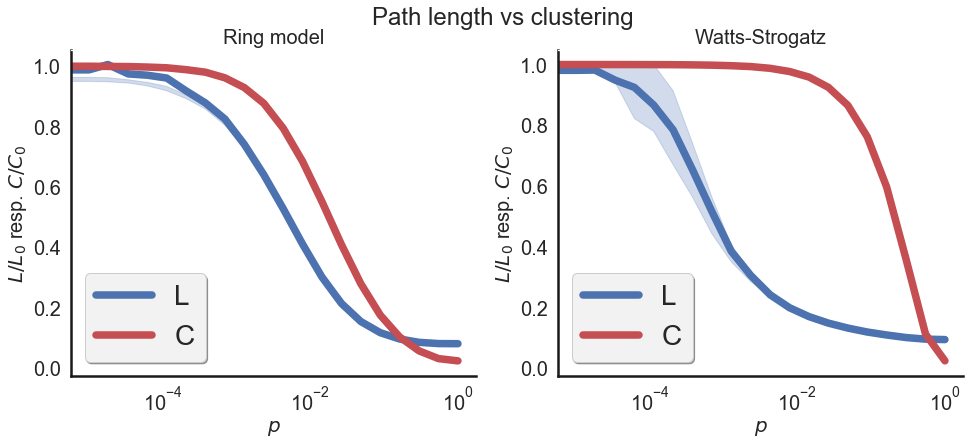

In [176]:
SI_fig, axes = plt.subplots(1,2, figsize=(16,6))
SI_fig.patch.set_alpha(0)
SI_fig.suptitle('Path length vs clustering', fontsize=24)


plt.semilogx(p, ws_L_mean/ws_L0, linewidth=7.5, color='b', label='L');
plt.semilogx(p, ws_C_mean/ws_C0, linewidth=7.5, color='r' , label='C');

plt.fill_between(p, ws_L_25.flatten()/ws_L0 , ws_L_75.flatten()/ws_L0 , alpha=0.25, color='b');
plt.fill_between(p, ws_C_25.flatten()/ws_C0 , ws_C_75.flatten()/ws_C0 , alpha=0.25, color='r');

axes[1].set_xlabel(r'$p$', fontsize=20)
axes[1].set_ylabel(r'$L/L_0$ resp. $C/C_0$', fontsize=20)
axes[1].set_title('Watts-Strogatz', fontsize=20);

axes[1].tick_params(axis='both', which='major', labelsize=20)

axes[1].spines['left'].set_linewidth(2.5)
axes[1].spines['left'].set_color('k')

axes[1].spines['bottom'].set_linewidth(2.5)
axes[1].spines['bottom'].set_color('k')

axes[1].legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0],
         loc='lower left');


axes[0].patch.set_alpha(0)
axes[1].patch.set_alpha(0)

axes[0].semilogx(p, my_L_mean/my_L0, linewidth=7.5, color='b', label='L');
axes[0].semilogx(p, my_C_mean/my_C0, linewidth=7.5, color='r' , label='C');

axes[0].fill_between(p, my_L_25.flatten()/my_L0 , my_L_75.flatten()/my_L0 , alpha=0.25, color='b');
axes[0].fill_between(p, my_C_25.flatten()/my_C0 , my_C_75.flatten()/my_C0 , alpha=0.25, color='r');

axes[0].set_xlabel(r'$p$', fontsize=20)
axes[0].set_ylabel(r'$L/L_0$ resp. $C/C_0$', fontsize=20)
axes[0].set_title('Ring model', fontsize=20);

axes[0].tick_params(axis='both', which='major', labelsize=20)

axes[0].spines['left'].set_linewidth(2.5)
axes[0].spines['left'].set_color('k')

axes[0].spines['bottom'].set_linewidth(2.5)
axes[0].spines['bottom'].set_color('k')

axes[0].legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0],
         loc='lower left');

In [177]:
SI_fig.savefig('FigureS4.pdf')